In [1]:
import os
import sys
import time
import pickle
BASE = '/home/wb/smp2018'
sys.path.append(BASE)

In [2]:
import gensim
import word2vec
import numpy as np
import multiprocessing
import pandas as pd
from init.config import Config
from tools import time_cost
from collections import defaultdict
from joblib import Parallel, delayed
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
from pyltp import SentenceSplitter

In [3]:
vec_dim = 256

In [4]:
cfg = Config()

In [5]:
data_base = '/home/wb/text-classification/data'

src = data_base + '/News_label.txt'

all_path = data_base + '/all.csv'

train_path = data_base + '/train.csv'

test_path = data_base + '/test.csv'

In [6]:
cfg.cache_dir = data_base

In [7]:
cfg.word_vocab_path = data_base + '/word_vocab.pk'
cfg.char_vocab_path = data_base + '/char_vocab.pk'

In [8]:
cfg.word_embed_path = data_base + '/word_embed.pk'
cfg.char_embed_path = data_base + '/char_embed.pk'

In [9]:
def get_train_all_data():
    train_all_data = pd.read_csv(all_path, sep='\t')
    return train_all_data

In [10]:
t0 = time.time()

In [11]:
def create_w2vc(overwrite=True):
    if overwrite:
        if os.path.exists(cfg.cache_dir + '/w2v_content_word.txt'):
            os.remove(cfg.cache_dir + '/w2v_content_word.txt')
        if os.path.exists(cfg.cache_dir + '/w2v_content_char.txt'):
            os.remove(cfg.cache_dir + '/w2v_content_char.txt')

        train_data = get_train_all_data()

        train_content = train_data["content"]

        print("len of all contents", len(train_content))

        def applyParallel(contents, func, n_thread):
            with Parallel(n_jobs=n_thread) as parallel:
                parallel(delayed(func)(c) for c in contents)

        def word_content(content):
            with open(cfg.cache_dir + "/w2v_content_word.txt", "a+") as f:
                f.writelines(content.lower())
                f.writelines('\n')

        def char_content(content):
            with open(cfg.cache_dir + "/w2v_content_char.txt", "a+") as f:
                content = content.lower().replace(" ", "")
                f.writelines(" ".join(content))
                f.writelines("\n")

        applyParallel(train_content, word_content, 25)
        applyParallel(train_content, char_content, 25)


    # word vector train
    model = gensim.models.Word2Vec(
        LineSentence(cfg.cache_dir + "/w2v_content_word.txt"),
        size=vec_dim,
        window=5,
        min_count=1,
        workers=multiprocessing.cpu_count()
    )
    model.save(cfg.cache_dir + "/content_w2v_word.model")

    # char vector train
    model = gensim.models.Word2Vec(
        LineSentence(cfg.cache_dir + '/w2v_content_char.txt'),
        size=vec_dim,
        window=5,
        min_count=1,
        workers=multiprocessing.cpu_count()
    )
    model.save(cfg.cache_dir + "/content_w2v_char.model")

- len of all contents 48,480

In [12]:
# create_w2vc(True)

In [13]:
t1 = time.time()

time_cost(t0, t1)



time cost 0hour 0minute




In [14]:
def create_word_emb(use_opened=False, overwriter=False):

    vocab = pickle.load(open(cfg.word_vocab_path, 'rb'))
    print(len(vocab))

    if use_opened:
        word_emb = [np.random.uniform(0, 0, 200) for j in range(len(vocab)+1)]
        model = word2vec.load(cfg.open_w2v_path)
    else:
        word_emb = [np.random.uniform(0, 0, 256) for j in range(len(vocab)+1)]
        model = gensim.models.Word2Vec.load(cfg.cache_dir + "/content_w2v_word.model")
    num = 0
    
    word_emb = np.array(word_emb)
    
    for word in vocab:
        index = vocab[word]
        if word in model:
            word_emb[index] = np.array(model[word])
            num += 1
        else:
            word_emb[index] = np.random.uniform(-0.5, 0.5, 256)
    print("word number: ", num)
    print("vocab size:", len(vocab))
    print("shape of word_emb", np.shape(word_emb))
    if overwriter:
        with open(cfg.word_embed_path, 'wb') as f:
            pickle.dump(word_emb, f)
            print("size of embedding_matrix: ", len(word_emb))
            print("word_embedding finish")

- size of word embedding_matrix:  655,382
- shape of word_emb (655,382, 256)

In [15]:
# create_word_emb(False, True)

In [16]:
time_cost(t0, time.time())



time cost 0hour 0minute




In [17]:
def create_char_emb(overwriter=False):

    vocab = pickle.load(open(cfg.char_vocab_path, 'rb'))
    char_emb = [np.random.uniform(0, 0, 256) for j in range(len(vocab)+1)]
    char_emb = np.array(char_emb)
    model = gensim.models.Word2Vec.load(cfg.cache_dir + "/content_w2v_char.model")
    num = 0
    for char in vocab:
        index = vocab[char]
        if char in model:
            char_emb[index] = np.array(model[char])
            num += 1
        else:
            char_emb[index] = np.random.uniform(-0.5, 0.5, 256)
    print("char number: ", num)
    print("vocab size:", len(vocab))
    print("shape of char_emb", np.shape(char_emb))
    if overwriter:
        with open(cfg.char_embed_path, 'wb') as f:
            pickle.dump(char_emb, f)
            print("size of embedding_matrix: ", len(char_emb))
            print("char_embedding finish")

- size of char embedding_matrix:  9,888
- shape of char_emb (9,888, 256)

In [18]:
# create_char_emb(True)

In [19]:
time_cost(t0, time.time())



time cost 0hour 0minute




In [20]:
def create_word_vocab(overwriter=False):
    word_freq = defaultdict(int)

    train_data = get_train_all_data()
    train_content = train_data["content"]
    
    start = time.time()

    for line in train_content:
        line = line.lower().strip()
        words = line.split(" ")
        for word in words:
            if " " == word or "" == word:
                continue
            word_freq[word] += 1
    
    time_cost(start, time.time())

    
    vocab = {}
    i = 1
    min_freq = 1
    for word, freq in word_freq.items():
        if freq >= min_freq:
            vocab[word] = i
            i += 1
    vocab['NUM'] = i
    vocab['UNK'] = i+1
    print("size of vocab:", len(vocab))

    if overwriter:
        vocab_file = cfg.cache_dir + '/word_vocab.pk'
        with open(vocab_file, 'wb') as f:
            pickle.dump(vocab, f)
        print("finish to create vocab !")
        time_cost(start, time.time())

- size of word vocab: 655,381

In [21]:
# create_word_vocab(True)

In [22]:
t1 = time.time()

time_cost(t0, t1)



time cost 0hour 0minute




In [23]:
def create_char_vocab(overwriter=False):
    char_freq = defaultdict(int)

    train_data = get_train_all_data()
    train_content = train_data["content"]
    
    start = time.time()

    for line in train_content:
        line = line.lower().strip()
        line = line.replace(" ", "")
        chars_line = " ".join(line)
        chars = chars_line.split(" ")
        for char in chars:
            if " " == char or "" == char:
                continue
            char_freq[char] += 1
    
    time_cost(start, time.time())

    
    vocab = {}
    i = 1
    min_freq = 1
    for char, freq in char_freq.items():
        if freq >= min_freq:
            vocab[char] = i
            i += 1
    vocab['NUM'] = i
    vocab['UNK'] = i+1
    print(vocab)
    print("size of vocab:", len(vocab))

    if overwriter:
        vocab_file = cfg.cache_dir + '/char_vocab.pk'
        with open(vocab_file, 'wb') as f:
            pickle.dump(vocab, f)
        time_cost(start, time.time())

- size of char vocab: 9,887

In [24]:
# char_vocab = create_char_vocab(True)

统计信息

In [25]:
def save_dict(d, save_path):
    f = open(save_path, "w")
    for key in d:
        f.write(str(key)+","+ str(d[key]) +'\n')
    f.close()

In [26]:
def count_sentence_num_length():
    train_data = get_train_all_data()
    train_content = train_data["content"]
    train_labels = train_data["label"]

    train_num_dict = defaultdict(int)
    good_train_num_dict = defaultdict(int)
    poor_train_num_dict = defaultdict(int)
    bad_train_num_dict = defaultdict(int)

    for i in range(len(train_content)):
        content = train_content[i].lower().strip()
        sentences = SentenceSplitter.split(content)
        sent_num = len(sentences)
        train_num_dict[sent_num] += 1
        
        if train_labels[i] == 0:
            good_train_num_dict[sent_num] += 1
        elif train_labels[i] == 1:
            poor_train_num_dict[sent_num] += 1
        elif train_labels[i] == 2:
            bad_train_num_dict[sent_num] += 1
        else:
            print("wrong", train_labels[i])
    save_dict(train_num_dict, cfg.cache_dir + "/train_sen_num.csv")
    save_dict(good_train_num_dict, cfg.cache_dir + "/good_sen_num.csv")
    save_dict(poor_train_num_dict, cfg.cache_dir + "/poor_sen_num.csv")
    save_dict(bad_train_num_dict, cfg.cache_dir + "/bad_sen_num.csv")


In [27]:
# count_sentence_num_length()

In [28]:
def count_word_sentence_length():
    train_data = get_train_all_data()
    train_content = train_data["content"]
    train_labels = train_data["label"]

    train_word_num_dict = defaultdict(int)
    good_word_num_dict = defaultdict(int)
    poor_word_num_dict = defaultdict(int)
    bad_word_num_dict = defaultdict(int)

    for i in range(len(train_content)):
        content = train_content[i].lower().strip()
        sentences = SentenceSplitter.split(content)
        word_count = 0
        for sent in sentences:
            sent = sent.strip()
            word_count += len(sent.split(" "))
        train_word_num_dict[word_count] += 1
        if train_labels[i] == 0:
            good_word_num_dict[word_count] += 1
        elif train_labels[i] == 1:
            poor_word_num_dict[word_count] += 1
        elif train_labels[i] == 2:
            bad_word_num_dict[word_count] += 1
        else:
            print("wrong", train_labels[i])
    save_dict(train_word_num_dict, cfg.cache_dir + "/train_word_sen_len.csv")
    save_dict(good_word_num_dict, cfg.cache_dir + "/good_word_sen_len.csv")
    save_dict(poor_word_num_dict, cfg.cache_dir + "/poor_word_sen_len.csv")
    save_dict(bad_word_num_dict, cfg.cache_dir + "/bad_word_sen_len.csv")


In [29]:
# count_word_sentence_length()

In [30]:
def count_char_sentence_length():
    train_data = get_train_all_data()
    train_content = train_data["content"]
    train_labels = train_data["label"]

    train_char_num_dict = defaultdict(int)
    good_char_num_dict = defaultdict(int)
    poor_char_num_dict = defaultdict(int)
    bad_char_num_dict = defaultdict(int)

    for i in range(len(train_content)):
        content = train_content[i].lower().strip()
        sentences = SentenceSplitter.split(content)
        char_count = 0
        for sent in sentences:
            sent = sent.strip()
            line = sent.replace(" ", "")
            chars_line = " ".join(line)
            chars = chars_line.split(" ")
            char_count += len(chars)

        train_char_num_dict[char_count] += 1
        if train_labels[i] == 0:
            good_char_num_dict[char_count] += 1
        elif train_labels[i] == 1:
            poor_char_num_dict[char_count] += 1
        elif train_labels[i] == 2:
            bad_char_num_dict[char_count] += 1
        else:
            print("wrong", train_labels[i])
    save_dict(train_char_num_dict, cfg.cache_dir + "/train_char_sen_len.csv")
    save_dict(good_char_num_dict, cfg.cache_dir + "/good_char_sen_len.csv")
    save_dict(poor_char_num_dict, cfg.cache_dir + "/poor_char_sen_len.csv")
    save_dict(bad_char_num_dict, cfg.cache_dir + "/bad_char_sen_len.csv")

In [31]:
# count_char_sentence_length()

可视化数据界面

In [86]:
word_df = pd.read_csv(cfg.cache_dir + "/train_char_sen_len.csv", header=None)

word_df = word_df.sort_values(by=[0])

In [87]:
word_df

,0,1
2070,2,3
1325,4,13
3699,5,1
1170,6,8
3716,7,1
204,8,22
855,9,20
618,10,50
189,11,30
451,12,54


In [88]:
x = word_df.set_index(0)

In [89]:
import matplotlib.pyplot as plt
% matplotlib inline

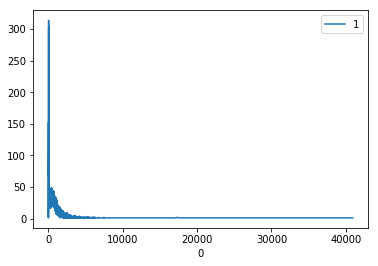

In [90]:
x.plot()

In [91]:
total_sen = sum(word_df[1])

In [92]:
head1000_sen = sum(word_df.head(2000)[1])

In [93]:
head1000_sen / total_sen

0.9165841584158416

In [94]:
word_df[2] = word_df.apply(lambda x: x[0] * x[1], axis=1)

In [95]:
total_words = sum(word_df.head(2000)[2])

In [96]:
ave = total_words / head1000_sen

In [97]:
ave

619.2711990278153